In [1]:
import os

import pandas as pd
from utils import uniform_split, plot_df_language_distribution, get_indexes_per_language, plot_language_distribution, get_client_weights, FedAlgo, label
from federate import federated_train
import torch

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

2.7.0+cu118


'cuda'

In [2]:
MODEL_PATH = "mBERT" # I have donloaded distilled mBERT (hugggingface not available in China)
# MODEL_PATH = "distilbert-base-multilingual-cased"
DATA_DIR = "data"
seed = 42

In [3]:
portion = 0.1
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv")).sample(frac=portion, random_state=seed)
val_df = pd.read_csv(os.path.join(DATA_DIR, "validation.csv")).sample(frac=portion, random_state=seed)
test_df = pd.read_csv(os.path.join(DATA_DIR, "test.csv")).sample(frac=portion, random_state=seed)
languages = list(train_df.language.unique())

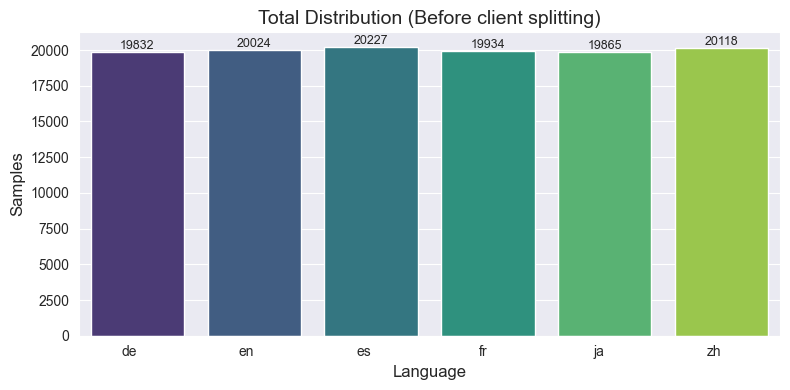

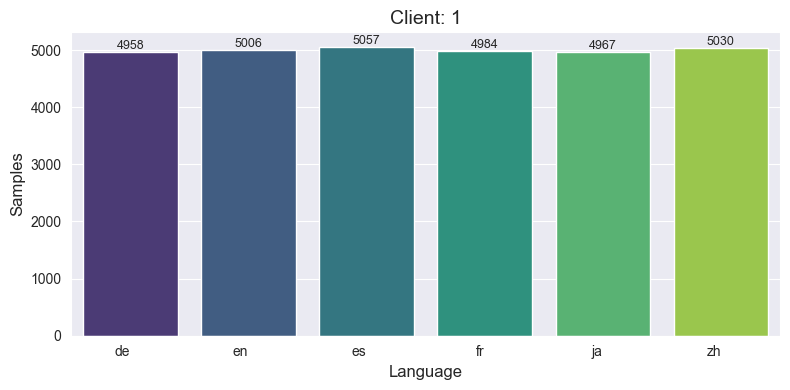

In [4]:
lang_to_indices = get_indexes_per_language(train_df)
plot_df_language_distribution(train_df, languages, "Total Distribution (Before client splitting)")
plot_language_distribution([uniform_split(train_df, lang_to_indices.copy(), seed=42)[0]], languages)

In [5]:
# ==== Tokenizer ====
print("Loading tokenizer from local path...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

def tokenize(example):
    return tokenizer(example["review_body"], truncation=True, padding="max_length",max_length=512)

val_ds = label(val_df)
test_ds = label(test_df)

val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

columns_to_keep = ["input_ids", "attention_mask", "label"]
val_ds.set_format(type="torch", columns=columns_to_keep)
test_ds.set_format(type="torch", columns=columns_to_keep)

Loading tokenizer from local path...


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [6]:
from utils import dirichlet_split

def get_client_datasets(beta):
    client_datasets = []
    if beta == -1:
        client_dfs = uniform_split(train_df, lang_to_indices.copy(), seed=seed)
    else:
        client_dfs = dirichlet_split(train_df, lang_to_indices, beta=beta, seed=seed)
    plot_df_language_distribution(train_df, languages, "Total Distribution (Before client splitting)")
    plot_language_distribution(client_dfs, languages)
    for client in client_dfs:
        curr = label(client).map(tokenize, batched=True)
        curr.set_format(type="torch", columns=columns_to_keep)
        client_datasets.append(curr)
    return client_datasets

In [7]:
NUM_LABELS = 3

# ==== Load Model ====
print("Loading model from local path...")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=NUM_LABELS)

# ==== Metrics ====
BATCH_SIZE = 32
EPOCHS = 3

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at mBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model from local path...


## Experiments

### FedAvg

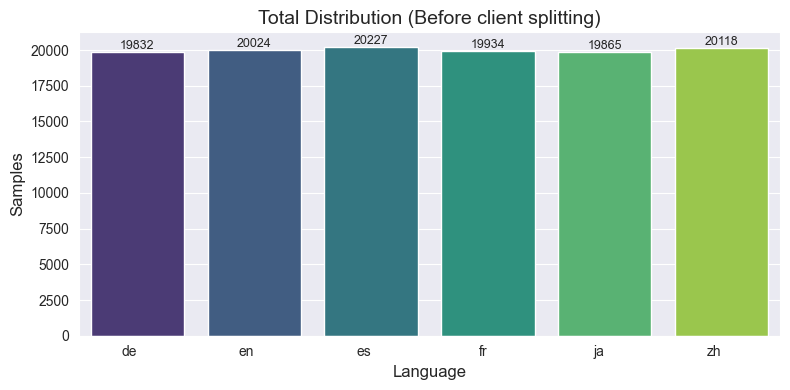

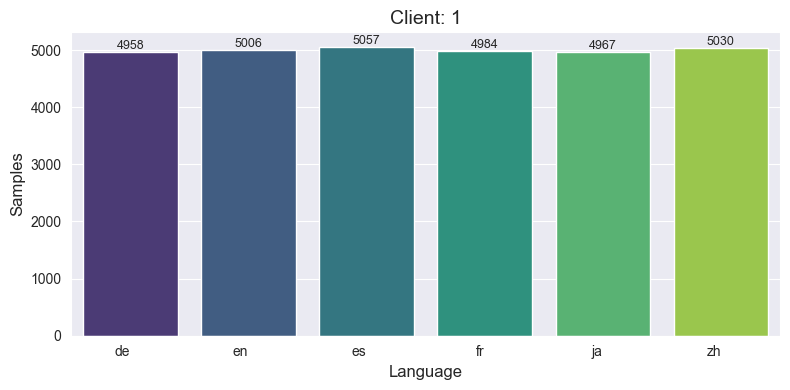

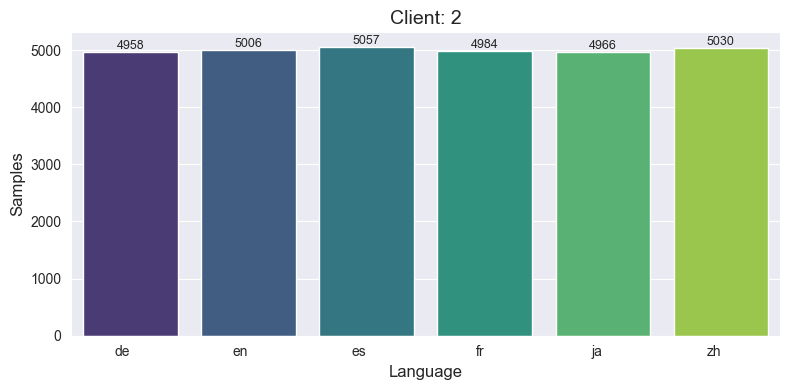

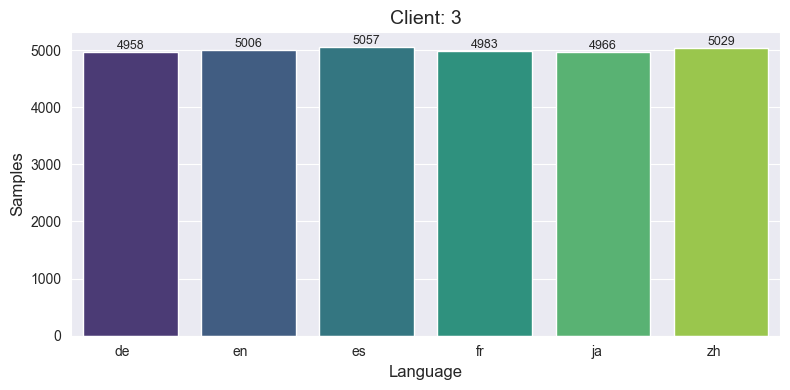

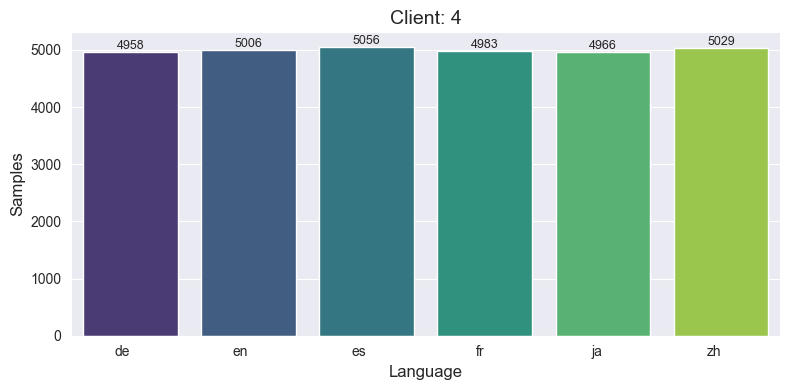

Map:   0%|          | 0/30002 [00:00<?, ? examples/s]

Map:   0%|          | 0/30001 [00:00<?, ? examples/s]

Map:   0%|          | 0/29999 [00:00<?, ? examples/s]

Map:   0%|          | 0/29998 [00:00<?, ? examples/s]


--- Global Round 1/3 ---
 Evaluating global model before client updates...
{'eval_loss': 1.103010892868042, 'eval_model_preparation_time': 0.001, 'eval_accuracy': 0.393, 'eval_f1': 0.22315456358416957, 'eval_runtime': 4.6013, 'eval_samples_per_second': 651.988, 'eval_steps_per_second': 20.429}
 Global Evaluation (Round 1): {'eval_loss': 1.103010892868042, 'eval_model_preparation_time': 0.001, 'eval_accuracy': 0.393, 'eval_f1': 0.22315456358416957, 'eval_runtime': 4.6013, 'eval_samples_per_second': 651.988, 'eval_steps_per_second': 20.429}
 Training on Client 1/4...


In [ ]:
# Uniform - FedAvg
run_name = "FedAvg_uniform"
client_datasets = get_client_datasets(beta=-1)
federated_train(
    base_model=model,
    client_datasets=client_datasets,
    val_ds=val_ds,
    test_ds=test_ds,
    client_weights=get_client_weights(client_datasets, FedAlgo.FedAvg),
    local_epochs=2,
    global_rounds=3,
    batch_size=BATCH_SIZE,
    learning_rate=5e-5,
    device=device,
    run_name=run_name
)

In [ ]:
# Beta - 0.1, FedAvg
run_name = "FedAvg_b01"
client_datasets = get_client_datasets(beta=0.1)
federated_train(
    base_model=model,
    client_datasets=client_datasets,
    val_ds=val_ds,
    test_ds=test_ds,
    client_weights=get_client_weights(client_datasets, FedAlgo.FedAvg),
    local_epochs=2,
    global_rounds=3,
    batch_size=BATCH_SIZE,
    learning_rate=5e-5,
    device=device,
    run_name=run_name
)

In [ ]:
# Beta - 0.5, FedAvg
run_name = "FedAvg_b05"
client_datasets = get_client_datasets(beta=0.5)
federated_train(
    base_model=model,
    client_datasets=client_datasets,
    val_ds=val_ds,
    test_ds=test_ds,
    client_weights=get_client_weights(client_datasets, FedAlgo.FedAvg),
    local_epochs=2,
    global_rounds=3,
    batch_size=BATCH_SIZE,
    learning_rate=5e-5,
    device=device,
    run_name=run_name
)

In [ ]:
# Beta - 0.9, FedAvg
run_name = "FedAvg_b09"
client_datasets = get_client_datasets(beta=0.9)
federated_train(
    base_model=model,
    client_datasets=client_datasets,
    val_ds=val_ds,
    test_ds=test_ds,
    client_weights=get_client_weights(client_datasets, FedAlgo.FedAvg),
    local_epochs=2,
    global_rounds=3,
    batch_size=BATCH_SIZE,
    learning_rate=5e-5,
    device=device,
    run_name=run_name
)

### FedDisco

In [ ]:
# Uniform - FedDisco
run_name = "FedDisco_uniform"

In [ ]:
# Beta 0.1 - FedDisco
run_name = "FedDisco_b01"

In [ ]:
# Beta 0.5 - FedDisco
run_name = "FedDisco_b05"

In [ ]:
# Beta 1 - FedDisco
run_name = "FedDisco_b1"